<h1><center>PHYS-F-303</center></h1>
<h1><center>Partie numérique</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

In [131]:
import time,numba
from numba import jit
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

# Leçon 06_02

## Question 1

## Question 2

Nous codons ici la méthode dite de "Box-Muller".

In [2]:
N = 10000

u1 = np.random.random_sample(N)
u2 = np.random.random_sample(N)

In [3]:
z0 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
z1 = np.sqrt(-2*np.log(u2))*np.sin(2*np.pi*u1)

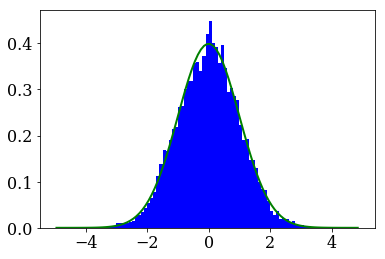

In [4]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z0,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

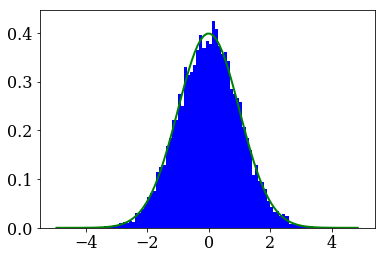

In [5]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z1,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

# Leçon 06_03

## Question 1

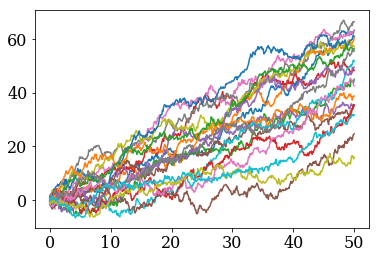

In [6]:
npart=10000
T=50.0
nt=500
dt=T/nt
alpha=2
c = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)+c*dt

for i in range(20):
    plt.plot(t,x[:,i])

On remarque une translation générale des particules vers les $x$ positifs si $c$ est positif et vers les $x$ négatifs si $c$ est négatif. 

## Question 2

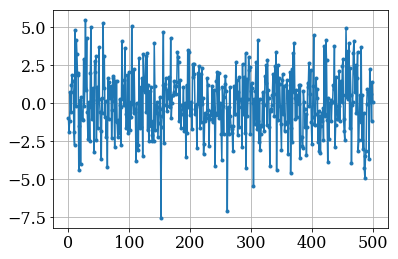

In [7]:
npart=2000
npart2plot = 1

T = 500.0
dt = 1
nt = int(T/dt)+1
alpha = 2
gamma = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(npart2plot):
    plt.plot(t,x[:,i],'.-')
plt.grid()

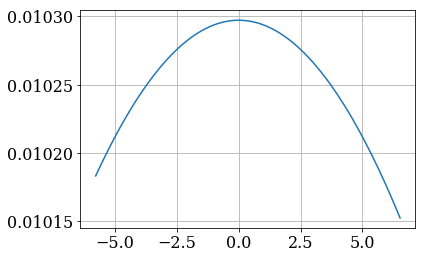

In [8]:
# Generate bins centered around 0
xmin = np.min(x[nt-1])
xmax = np.max(x[nt-1])

binwidth = (xmax-xmin)/100

bins=np.arange(xmin,xmax,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
#plt.hist(x[nt-1],bins,normed=True);

sigmat2=2*alpha*T+sigma**2-gamma*T
plt.plot(bin_centers,np.exp(-bin_centers**2/(2.0*sigmat2))/np.sqrt(2*np.pi*sigmat2))
plt.grid()

In [9]:
sigmat2

1501.0

A cause du terme de friction, on remarque une atténuation de l'écart par rapport à la position centrale pour des $\gamma <2$. Faire varier l'écart-type pour contracrrer l'effet d'un $\gamma$ trop grand?

# Remarques

Algorithme instable! On remarque que pour des $\gamma$ au-delà de 2, il y a comme une divergence.

/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1918: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/cedric/Coding/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1944: RuntimeWarning: overflow encountered in double_scalars
  high = np.round(Base(step).ge(_vmax - best_vmin) / step)


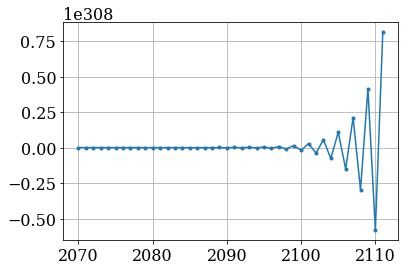

In [10]:
npart=1

T = 10000.0
dt = 1
nt = int(T/dt)+1
alpha=2
gamma = 2.4

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(1):
    plt.plot(t[2070:2200],x[2070:2200,i],'.-')
plt.grid()

# Leçon  06_04: Modèle d'Ising

## Challenge (vers le milieu du MOOC)

## Question 1: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

Nous calculons la magnétisation moyenne comme: $$ \left \langle M \right \rangle = \dfrac{\sum_{k=1}^{N} M_k }{N} $$ avec $M_k = \sum_{i=1}^{b} s_i$ où $N$ est le nombre de tranches simulées et $b$ le nombre de cases dans une tranche dans lesquelles se trouvent les spins que nous sommons.

Commençons par définir les fonctions à utiliser pour observer l'évolution de la magnétisation pour un alpha donné.

In [126]:
def initial_state_random(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [127]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [132]:
@jit
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]\
                         +sp[ix,(iy+1)%ny])

    return energy

In [133]:
@jit
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [134]:
@jit
def moy_magn(sp): 
    """ Computes the average magnetisation for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    M: average magnetisation for the lattice state sp 
    """
    
    M = sp.sum(axis=(0,1))/(len(sp)*len(sp[0]))
    return M

In [135]:
@jit
def moy_ener(sp): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energy for the lattice state sp 
    """
    
    pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
    pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
    pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
    pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
    E = -alpha * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                  + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
    E = E/(len(sp)*len(sp[0]))
           
    return E

In [136]:
@jit
def M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling constant for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    M: magnetisation 
    E: energie 
    """
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp)
    return [M,E]

Calculons l'évolution de la magnétisation pour un alpha donné afin de vérifier que le code fonctionne bien.

In [91]:
NMC = 300 
step = 1
nx = 20 
ny = 20
alpha = 0.35

sp = initial_state_aligned(nx,ny)
E_aligned = moy_ener(sp)

[M,E] = M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha)

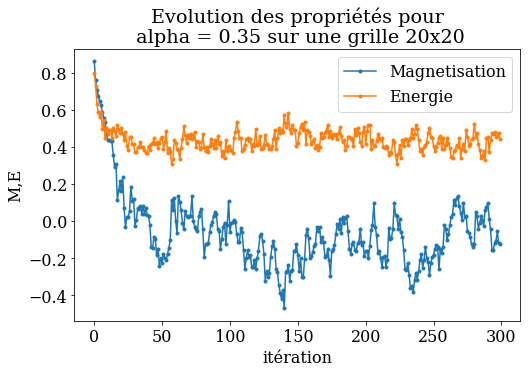

In [92]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),E/E_aligned, '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.show()

Ce graphique nous permet d'estimer le nombre d'itération nécessaire pour atteindre un équilibre statistique. Nous allons en avoir besoin pour calculer les propriétés (magnétisation et énergie) du sysème à l'équilibre. Pour automatiser ce calcul pour plusieurs valeurs de $\alpha$, il nécessaire de s'assurer que le nombre d'itération attendues pour atteindre l'équilbre majore celui nécessaire pour chaque valeur de $\alpha$. C'est pourquoi nous avons testé plusieurs valeurs de alpha et choisi pour ce graphique une valeur de alpha parmi celles qui met le plus de temps à atteindre l'équilibre pour un état initial de spins alignés. Nous avons répété plusieurs fois l'algorithme pour cette valeur et avons observé que l'équilibre était toujours atteint avant 50 itérations. Notons que pour des valeurs de alpha proche de la transition (vers 0.4), les propriétés du système (magnétisation, énergie) fluctuent beaucoup.

Automatisons maintenant la procédure pour calculer la magnétisation à l'équilibre pour un grand nombre de couplages différents.

In [137]:
@jit
def M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq):
    """ Computes averages of physical quantities at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    Returns:
    -------
    Ms     : Vector of magnetisations at equilibrium for each alpha in alphas
    Es     : Vector of energis at equilibrium for each alpha in alphas
    VarEs  : Vector of the variances of the energy at equilibrium for each alpha in alphas
    """
    
    Ms  = np.empty([len(alphas)])
    Es  = np.empty([len(alphas)])
    VarEs = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.3f}".format(alphas[i]))
        
        for j in range(NMC_eq):
            
            #if j%(int(NMC_eq/10)+1)==0:
                #print("loop {:d} of {:d} for alpha = {:.2f} (pre-equilibrium)".format(j,NMC_eq,alphas[i]))
            for j in range(0,nx*ny):
                ix = np.random.randint(0,nx)
                iy = np.random.randint(0,ny)
                metropolis_at_site(sps[i],alphas[i],ix,iy)
        
        [M_evol,E_evol] = M_with_time_for_alpha(sps[i],nx,ny,NMC,step,alphas[i])
        Ms[i]  = M_evol.sum()/len(M_evol)
        Es[i]  = E_evol.sum()/len(E_evol)
        VarEs[i] = (E_evol**2).sum()/len(E_evol) - (E_evol.sum()/len(E_evol))**2
    
    return [Ms,Es,VarEs]

Calculons donc la magnétisation d'équilbre pour plusieurs valeurs de $\alpha$.

In [145]:
NMC = 50+100
NMC_eq = 50
step = 1
nx = 20
ny = 20
a = 101 # 51
alphas = np.linspace(0,1,a)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
E_aligned = moy_ener(sps[0])

[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)

loop at alpha = 0.000
loop at alpha = 0.010
loop at alpha = 0.020
loop at alpha = 0.030
loop at alpha = 0.040
loop at alpha = 0.050
loop at alpha = 0.060
loop at alpha = 0.070
loop at alpha = 0.080
loop at alpha = 0.090
loop at alpha = 0.100
loop at alpha = 0.110
loop at alpha = 0.120
loop at alpha = 0.130
loop at alpha = 0.140
loop at alpha = 0.150
loop at alpha = 0.160
loop at alpha = 0.170
loop at alpha = 0.180
loop at alpha = 0.190
loop at alpha = 0.200
loop at alpha = 0.210
loop at alpha = 0.220
loop at alpha = 0.230
loop at alpha = 0.240
loop at alpha = 0.250
loop at alpha = 0.260
loop at alpha = 0.270
loop at alpha = 0.280
loop at alpha = 0.290
loop at alpha = 0.300
loop at alpha = 0.310
loop at alpha = 0.320
loop at alpha = 0.330
loop at alpha = 0.340
loop at alpha = 0.350
loop at alpha = 0.360
loop at alpha = 0.370
loop at alpha = 0.380
loop at alpha = 0.390
loop at alpha = 0.400
loop at alpha = 0.410
loop at alpha = 0.420
loop at alpha = 0.430
loop at alpha = 0.440
loop at al

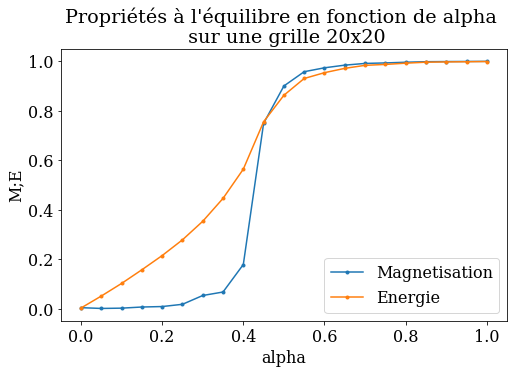

In [95]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas,abs(Es/E_aligned), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.show()

Notons que nous affichons la valeur absolue de la magnétisation, car celle-ci peut converger vers n'importe laquelle des deux orientations. En ce qui concerne l'énergie, nous la divisons par la valeur d'énergie pour un réseau de spins entièrement alignés et prenons ensuite la valeur absolue.

In [ ]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas,abs(Es/E_aligned), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.show()

Sur base du graphique des propriétés à l'équibre en fonction du couplage, nous pouvons observer une nette augmention de la magnétisation totale à partir de $\alpha = 0.4$. Nous pouvons donc fournir une première estimation de la valeur critique de $\alpha$, qui doit donc avoisiner $0.4$.

Pour plus de précision sur cette valeur, nous pouvons définir le couplage critique comme la valeur de $\alpha$ où la courbe de magnétisation passe au dessus de $0.5$. Ce point est arbitraire mais vu la valeur très élevée de la pente près du vrai couplage critique, cela devrait constituer une bonne approximation de ce dernier.

In [96]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.43 \pm 0.02


Ce résultat est proche de la valeur théorique obtenue par Onsager, qui est:

$$ \alpha = \frac{\ln( 1+\sqrt 2 )}{2} \approx 0.441$$

Gardons évidemment en tête que ce résultat est valable dans la limite où le réseau est de taille infine, le nôtre n'étant consititué que de 20x20 spins.

Cependant, une autre méthode existe pour déterminer cette valeur critique. Elle consiste à observer la capacité calorifique en fonction de $\alpha$, le graphique devant présenter un pic à la valeur critique de couplage. $<$ reference $>$.

Etant donné la relation suivante et la constance de la température. $<$ sûr ? $>$

$$ c_v = \frac{\text{var}(E)}{kT^2} $$

les énergies étant déjà exprimées en unités de $J/kT$, nous pouvons porter la variance de l'énergie fois le couplage $\alpha = J/kT$ en fonction de alpha et déterminer le couplage critique, cette quantité étant proportionelle à $c_v$.

Pour plus de précision, nous allons relancer une simulation avec des valeurs de $\alpha$ plus raprochées et plus proches de la transition.

In [160]:
NMC = 50+5000
NMC_eq = 50
step = 1
nx = 20
ny = 20
alphas = np.concatenate((np.linspace(0,0.35,21) , np.linspace(0.35,0.55,201), np.linspace(0.55,1,21)))
a = len(alphas)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
E_aligned = moy_ener(sps[0])

start = time.time()
[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)
stop = time.time()
print(stop-start)

Cvs = VarEs*alphas

loop at alpha = 0.000
loop at alpha = 0.017
loop at alpha = 0.035
loop at alpha = 0.052
loop at alpha = 0.070
loop at alpha = 0.087
loop at alpha = 0.105
loop at alpha = 0.122
loop at alpha = 0.140
loop at alpha = 0.157
loop at alpha = 0.175
loop at alpha = 0.192


KeyboardInterrupt: 

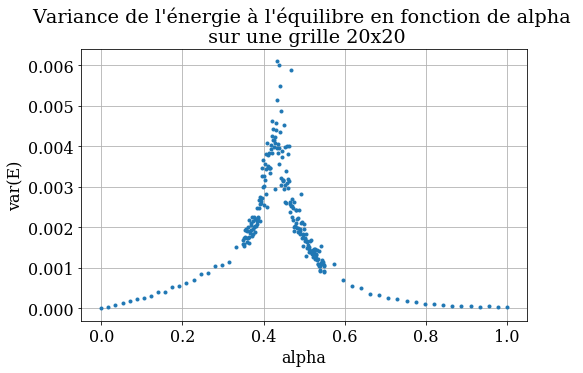

In [169]:
plt.figure(figsize=(8,5));
plt.plot(alphas,Cvs, '.');
plt.title("Variance de l'énergie à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('var(E)');
#plt.xlim([0.35,0.55]);
plt.grid();
plt.show()

Remarquons que la magnétisation et l'énergie ne se comportent pas de la même façon. Pour de petites valeurs de $\alpha$, la courbe d'énergie se trouve bien au dessus de la magnétisation, cela s'explique par le fait que plus $\alpha$ est grand, plus les spins voisins on tendance à s'aligner et diminuent l'énergie totale, alors que comme se phénomène d'alignement n'a pas lieu à grande échelle, la magnétisation reste petite. En effet, les contributions des différentes zones alignées se compensent et annulent la magnétisation totale. À grande valeurs de $\alpha$, ce phénomène a pour effet de former de vaste régions (de taille comparable à celle du système) de spins alignés dans une direction particulière, différente d'une région à l'autre. Ces régions sont apellées domaines de Weiss. Les domaines de Weiss on pour effet de diminuer fortement la magnétisation pour certaines valeurs de $\alpha$ pourtant au dessus de la valeur critique, alors que comme l'énergie est sommée sur les paires voisines, l'orientation différente des domaines ne se ressent qu'à la frontière entre ceux-ci et les diminutions sont donc beaucoup plus petites.

Sous réserve d'existence, nous recherchons et affichons ici un des réseaux qui présente une frontière entre deux domaines de Weiss pour une valeur au dessus de la valeur critique (majorée par 0.6). 

-1


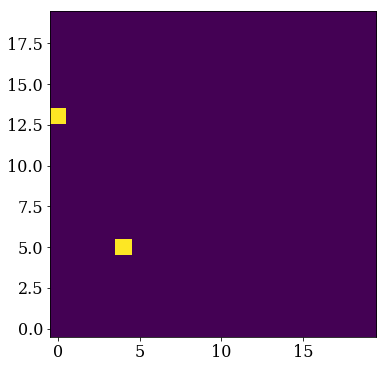

In [23]:
index_Weiss = -1
for i in range(len(alphas)):
    if (abs(Ms[i])<0.5) & (alphas[i]>0.6):
        index_Weiss = i

print(index_Weiss)

plt.figure(figsize=(6,6))
plt.imshow(sps[36],interpolation="none",origin='lower');

Remarquons que ces domaines de Weiss peuvent avoir fusionné avant la dernière itération et nous ne observons alors pas sur l'image. Nous pouvons toujours les faire apparaître en utilisant un plus petit nombre d'itérations. Avec plusieurs exécution du code ci-dessus, nous avons observé que la fusion des domaines arrive assez vite pour la taille choisie de notre système. C'est pourquoi nous avons jugé bon de prendre un nombre plus grand d'itérations que celui initialement prévu pour atteindre l'équilibre. Ainsi, en plus d'avoir atteint l'équilibre statistique dans les domaines, nous avons aussi pris le temps de les aligner, au détriment de la vitesse d'exécution de notre code.

Une technique qui serait peut être utile pour aller plus vite serait d'aligner les domaines en baignant le système dans un champ magnétique externe, pas trop intense afin de toujours observer la désorganisation thermique. Notons que phénomène d'alignement des domaines par un champ externe est celui qui expique pourquoi nous pouvons donner un moment dipolaire non nul à un morceau de fer en le mettant en contact avec un aimant.

## Question 2

## Remarques